In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import glob
from scipy.special import exp1,factorial
from scipy.stats import binom,nbinom
from scipy.special import gammaln
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
### Functions for theory

def get_lc(sigma,s):
    return np.sqrt(sigma**2/s)

def get_lambda_theory(w,sigma,s):
    lc = get_lc(sigma,s)
    term = (w / lc) ** 2
    if term <= 800:
        prod_term = np.exp(term) * exp1(term)
    else:
        prod_term = sum((factorial(k) / (-term)**k for k in range(7))) / term
    return (4*np.pi)/prod_term

def get_EP_theory(mu, s):
    return mu / s

def get_EPsquared_theory(mu, s, rho, sigma, w):
    lcs = get_lc(sigma, s)**2
    term = (w / np.sqrt(lcs)) ** 2
    if term <= 800:
        prod_term = np.exp(term) * exp1(term)
    else:
        prod_term = sum((factorial(k) / (-term)**k for k in range(7))) / term
    return (mu / (s ** 2 * rho * 4 * np.pi * lcs)) * prod_term + mu ** 2 / s ** 2

def get_sfs_theory(x,n,mu,s,rho,sigma,w):
    mean = get_EP_theory(mu,s)
    var = get_EPsquared_theory(mu,s,rho,sigma,w) - mean**2
    alpha = mean**2/var
    beta = mean/var
    return nbinom.pmf(x,alpha,beta/(beta+n))

def get_sfs_theory_unif(x,n,mu,s,N):
    mean = mu/s
    var = mu/(s*s*N)
    alpha = mean**2/var
    beta = mean/var
    return nbinom.pmf(x,alpha,beta/(beta+n))

### Comparison between theory and data

In [3]:
### Scale factors for y axis - from empiriaclplots_v20250217

len_syn = 1308.0216666666665
len_mis = 2616.043333333333
len_lof = 167.616

prop_kept_syn = 32320/247378
prop_kept_mis = 32320/505963
prop_kept_lof = 1

Optimize using one value of w... 

In [15]:
### Function 

def get_obs_dist(width,vartype,scale_factor,centers): # return counts: scale factor should be equal to prop_kept
    obs_dist_list = []
    if width is not None: # not uniform
        for center in centers: # average over centers
            sfs = pd.read_csv(f'../empirical/subsampling_SIR_v20250127/results/sfs/chr1_{vartype}_{center}geo{width}_nSIR10000_nSIRreps10.SIRsfs', sep=' ')
            sfs_grouped = sfs.groupby('OBS_N')['COUNT_SITES'].agg(['mean', 'std']) # average over replicates
            obs_dist_temp = sfs_grouped['mean'] / scale_factor # scale to adjust for downsampling
            obs_dist_list.append(obs_dist_temp)
        obs_dist = np.mean(obs_dist_list,axis=0)
    else: # uniform
        sfs = pd.read_csv(f'../empirical/subsampling_SIR_v20250127/results/sfs/chr1_{vartype}_uniformgeo_nSIR10000_nSIRreps10.SIRsfs', sep=' ')
        sfs_grouped = sfs.groupby('OBS_N')['COUNT_SITES'].agg(['mean', 'std']) # average over replicates
        obs_dist = sfs_grouped['mean'] / scale_factor # scale to adjust for downsampling
    return obs_dist

### Function to compare observed (data) to expected (theory) sfs and return log likelihood

def comp_logl(nb_dist,width,vartype,scale_factor,centers=['centerE9N9','centerE16N4','centerE6N4']):
    obs_dist = get_obs_dist(width,vartype,scale_factor,centers)
    obs_dist = obs_dist[1:len(nb_dist)+1]
    # log likelihood calculation log L = sum(OlogE-E-logO!)
    logl = np.sum(obs_dist * np.log(nb_dist) - nb_dist - gammaln(obs_dist + 1))  #log gamma is numerically stable implementation of log(O!)
    return logl

### Function for grid search

def grid_search(sigma_list,rho_list,s_list,w_list,mu_list,width,vartype,scale_factor,L_scale,max_x=10):
    logl_results = []
    n=10000
    for sigma in sigma_list:
        for rho in rho_list:
            for s in s_list:
                for w in w_list:
                    for mu in mu_list:
                        # nb dist needs to be counts - theory returns bp - convert to kb with *1000 and then to length of appropriate region with L_scale (in kb)
                        nb_dist = np.array([get_sfs_theory(y, n, mu, s, rho, sigma, w)*L_scale*1000 for y in np.arange(1, max_x+1)])
                        logl = comp_logl(nb_dist,width,vartype,scale_factor)
                        logl_results.append((sigma,rho,s,w,mu,logl))
    logl_results.sort(key=lambda x:x[5],reverse=True)
    return logl_results

### Function for grid search - 2 w

def grid_search_multiw(sigma_list,rho_list,s_list,w_list,mu_list,widths,vartype,scale_factor,L_scale,max_x=10):
    assert len(w_list) == len(widths), "w_list and width_list must be the same length"
    logl_results = []
    n=10000
    for sigma in sigma_list:
        for rho in rho_list:
            for s in s_list:
                for mu in mu_list:
                    logl_sum = 0
                    for i,w in enumerate(w_list):
                        # nb dist needs to be counts - theory returns bp - convert to kb with *1000 and then to length of appropriate region with L_scale (in kb)
                        nb_dist = np.array([get_sfs_theory(y, n, mu, s, rho, sigma, w)*L_scale*1000 for y in np.arange(1, max_x+1)])
                        logl_sum += comp_logl(nb_dist,width,vartype,scale_factor)
                    logl_results.append((sigma,rho,s,'multi',mu,logl_sum))
    logl_results.sort(key=lambda x:x[5],reverse=True)
    return logl_results

### Function to print grid search results

def print_res(results,vt,max_rank=20):
    print(f"Ranking of parameter combinations by best fit (highest logL), {vt} variants:")
    for rank, (sigma, rho, s, w, mu, logl) in enumerate(results, 1):
        if rank<=max_rank:
            print(f"{rank}. sigma={sigma}, rho={rho}, s={s:.1e}, w={w}, mu={mu:.2e}, logl={logl:.5f}")

### Plotting function -sfs

def plot_data_vs_theory(sigma, rho, s, mu=1.25e-8, n=10000, centers=['centerE9N9','centerE16N4','centerE6N4'],
                        widths_data=['50000','100000','150000',None], vartypes=['synonymous','missense','lof'],
                        scale_factors=[prop_kept_syn, prop_kept_mis, 1], maxval=50):
    colors = ['steelblue', 'orchid', 'darkorange']
    widths_theory = [50, 100, 150, 500]
    Lscale = [len_syn, len_mis, len_lof]
    
    fig, ax = plt.subplots(1, 4, figsize=(20, 5))
    x = np.logspace(0, 2)
    y = x**-1

    for i in [0, 1, 2, 3]:
        ax[i].loglog(x, y, color='lightgray', linestyle='--')
        ax[i].loglog(x, y * 10, color='lightgray', linestyle='--')
        ax[i].loglog(x, y * 100, color='lightgray', linestyle='--')
        ax[i].loglog(x, y / 100, color='lightgray', linestyle='--')
        ax[i].loglog(x, y / 10, color='lightgray', linestyle='--')

    for j, w in enumerate(widths_theory):
        nb_dist = [get_sfs_theory(y, n, mu, s, rho, sigma, w) * 1000 for y in np.arange(0, maxval)]
        ax[j].loglog(np.arange(0, maxval), nb_dist, marker=None, linestyle='-', linewidth=1, alpha=1, color='black', label=f'theory')

    for j, wid in enumerate(widths_data):
        for i, vt in enumerate(vartypes):
            sfs = get_obs_dist(wid, vt, scale_factors[i], centers=centers)
            sfs_kb = [x / Lscale[i] for x in sfs]
            ax[j].loglog(np.arange(0, maxval), sfs_kb[:maxval], marker='x', color=colors[i], linestyle='', label=vartypes[i])

    for i in [0, 1, 2, 3]:
        ax[i].set_ylim(1e-3, 1e2)
        ax[i].legend()

    ax[0].set_title('w=50km')
    ax[1].set_title('w=100km')
    ax[2].set_title('w=150km')
    ax[3].set_title('uniform')

    plt.show()

### Plotting function - heatmap

def plot_log_likelihood(res_df):
    res_df['rho'] = res_df['rho'].round(2)
    res_df['sigma'] = res_df['sigma'].round(2)
    
    filtered_data = res_df.loc[res_df.groupby(['sigma', 'rho'])['logl'].idxmax()]
    heatmap_data = filtered_data.pivot(index='rho', columns='sigma', values='logl')
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(heatmap_data, annot=True, cmap="plasma", fmt=".2f", annot_kws={"size": 6})
    plt.xlabel("Sigma")
    plt.ylabel("Rho")
    plt.title('log likelihood - Poisson')
    plt.show()


In [5]:
sigma_list = np.linspace(0.1,10,10)
rho_list = np.linspace(1,20,10)
s_list = np.logspace(-4,-2,10)
w_list = [50]
mu_list = [1.25e-8]
width = '50000'
vartype = 'missense'
scale_factor = prop_kept_mis
L_scale = len_mis

In [6]:
res = grid_search(sigma_list,rho_list,s_list,w_list,mu_list,width,vartype,scale_factor,L_scale,max_x=10)
print_res(res,'missense')

Ranking of parameter combinations by best fit (highest logL), missense variants:
1. sigma=10.0, rho=5.222222222222222, s=6.0e-03, w=50, mu=1.25e-08, logl=-2347.99152
2. sigma=5.6, rho=9.444444444444445, s=6.0e-03, w=50, mu=1.25e-08, logl=-2348.13615
3. sigma=2.3000000000000003, rho=15.777777777777779, s=6.0e-03, w=50, mu=1.25e-08, logl=-2349.31759
4. sigma=3.4000000000000004, rho=13.666666666666668, s=6.0e-03, w=50, mu=1.25e-08, logl=-2350.93901
5. sigma=0.1, rho=20.0, s=6.0e-03, w=50, mu=1.25e-08, logl=-2352.89628
6. sigma=4.5, rho=11.555555555555555, s=6.0e-03, w=50, mu=1.25e-08, logl=-2356.19493
7. sigma=1.2000000000000002, rho=20.0, s=6.0e-03, w=50, mu=1.25e-08, logl=-2362.92030
8. sigma=1.2000000000000002, rho=17.88888888888889, s=6.0e-03, w=50, mu=1.25e-08, logl=-2366.10849
9. sigma=7.800000000000001, rho=7.333333333333334, s=6.0e-03, w=50, mu=1.25e-08, logl=-2370.69409
10. sigma=6.7, rho=7.333333333333334, s=6.0e-03, w=50, mu=1.25e-08, logl=-2384.94002
11. sigma=2.30000000000000

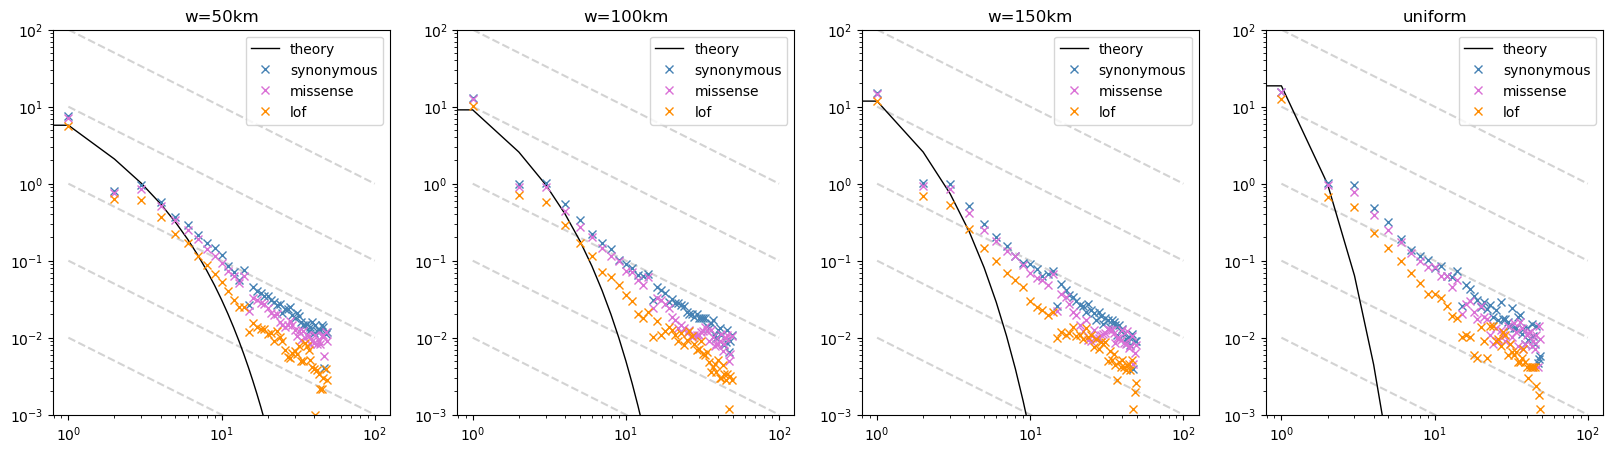

In [7]:
plot_data_vs_theory(10,5.222222222222222,6e-3)

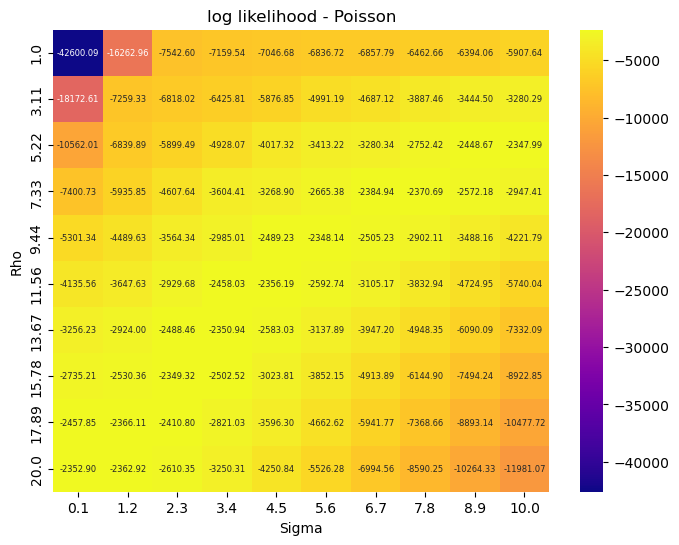

In [8]:
res_df = pd.DataFrame(res,columns=['sigma','rho','s','w','mu','logl'])
plot_log_likelihood(res_df)

Two values of w...

In [9]:
widths = ['50000','100000']
w_list = [50,100]
res2 = grid_search_multiw(sigma_list,rho_list,s_list,w_list,mu_list,widths,vartype,scale_factor,L_scale,max_x=10)
print_res(res2,'missense')

Ranking of parameter combinations by best fit (highest logL), missense variants:
1. sigma=0.1, rho=1.0, s=7.7e-04, w=multi, mu=1.25e-08, logl=nan
2. sigma=0.1, rho=3.111111111111111, s=7.7e-04, w=multi, mu=1.25e-08, logl=nan
3. sigma=0.1, rho=5.222222222222222, s=7.7e-04, w=multi, mu=1.25e-08, logl=nan
4. sigma=0.1, rho=7.333333333333334, s=7.7e-04, w=multi, mu=1.25e-08, logl=nan
5. sigma=0.1, rho=9.444444444444445, s=7.7e-04, w=multi, mu=1.25e-08, logl=nan
6. sigma=10.0, rho=3.111111111111111, s=6.0e-03, w=multi, mu=1.25e-08, logl=-6377.39307
7. sigma=4.5, rho=7.333333333333334, s=6.0e-03, w=multi, mu=1.25e-08, logl=-7556.32888
8. sigma=0.1, rho=9.444444444444445, s=6.0e-03, w=multi, mu=1.25e-08, logl=-9926.18326
9. sigma=0.1, rho=7.333333333333334, s=6.0e-03, w=multi, mu=1.25e-08, logl=-10964.29193
10. sigma=0.1, rho=9.444444444444445, s=3.6e-03, w=multi, mu=1.25e-08, logl=-12197.51502
11. sigma=0.1, rho=7.333333333333334, s=3.6e-03, w=multi, mu=1.25e-08, logl=-12415.40669
12. sigma=

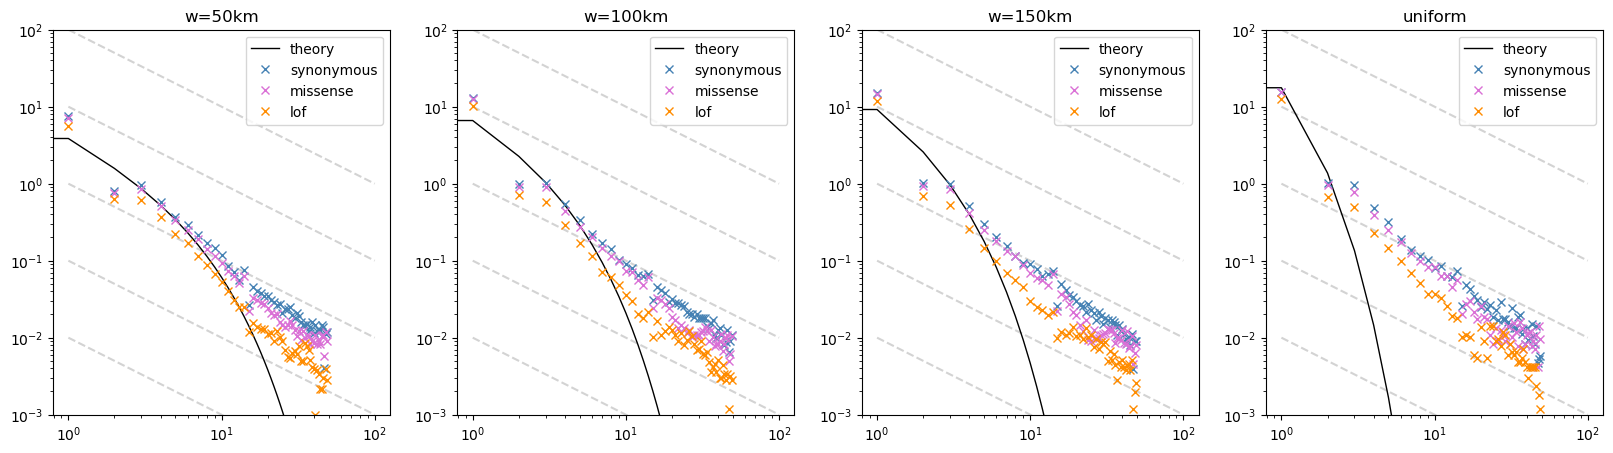

In [10]:
plot_data_vs_theory(10,3.111111111111111,6e-3)

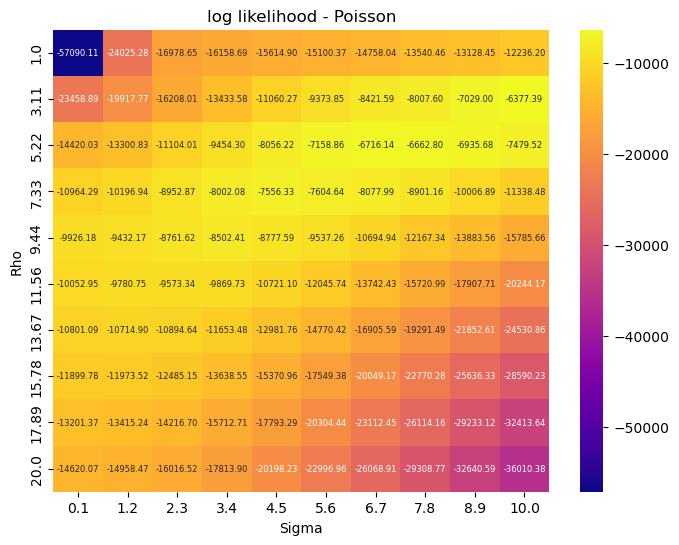

In [11]:
res_df2 = pd.DataFrame(res2,columns=['sigma','rho','s','w','mu','logl'])
plot_log_likelihood(res_df2)

3 values...

In [12]:
widths = ['50000','100000','150000']
w_list = [50,100,150]
res3 = grid_search_multiw(sigma_list,rho_list,s_list,w_list,mu_list,widths,vartype,scale_factor,L_scale,max_x=10)
print_res(res3,'missense')

Ranking of parameter combinations by best fit (highest logL), missense variants:
1. sigma=0.1, rho=1.0, s=7.7e-04, w=multi, mu=1.25e-08, logl=nan
2. sigma=0.1, rho=3.111111111111111, s=7.7e-04, w=multi, mu=1.25e-08, logl=nan
3. sigma=0.1, rho=5.222222222222222, s=7.7e-04, w=multi, mu=1.25e-08, logl=nan
4. sigma=10.0, rho=3.111111111111111, s=6.0e-03, w=multi, mu=1.25e-08, logl=-11661.42168
5. sigma=4.5, rho=5.222222222222222, s=6.0e-03, w=multi, mu=1.25e-08, logl=-15334.64389
6. sigma=2.3000000000000003, rho=5.222222222222222, s=6.0e-03, w=multi, mu=1.25e-08, logl=-17717.96106
7. sigma=0.1, rho=5.222222222222222, s=6.0e-03, w=multi, mu=1.25e-08, logl=-20485.31144
8. sigma=0.1, rho=7.333333333333334, s=7.7e-04, w=multi, mu=1.25e-08, logl=nan
9. sigma=0.1, rho=7.333333333333334, s=6.0e-03, w=multi, mu=1.25e-08, logl=-20673.46526
10. sigma=0.1, rho=7.333333333333334, s=3.6e-03, w=multi, mu=1.25e-08, logl=-25849.38823
11. sigma=0.1, rho=5.222222222222222, s=1.0e-02, w=multi, mu=1.25e-08, l

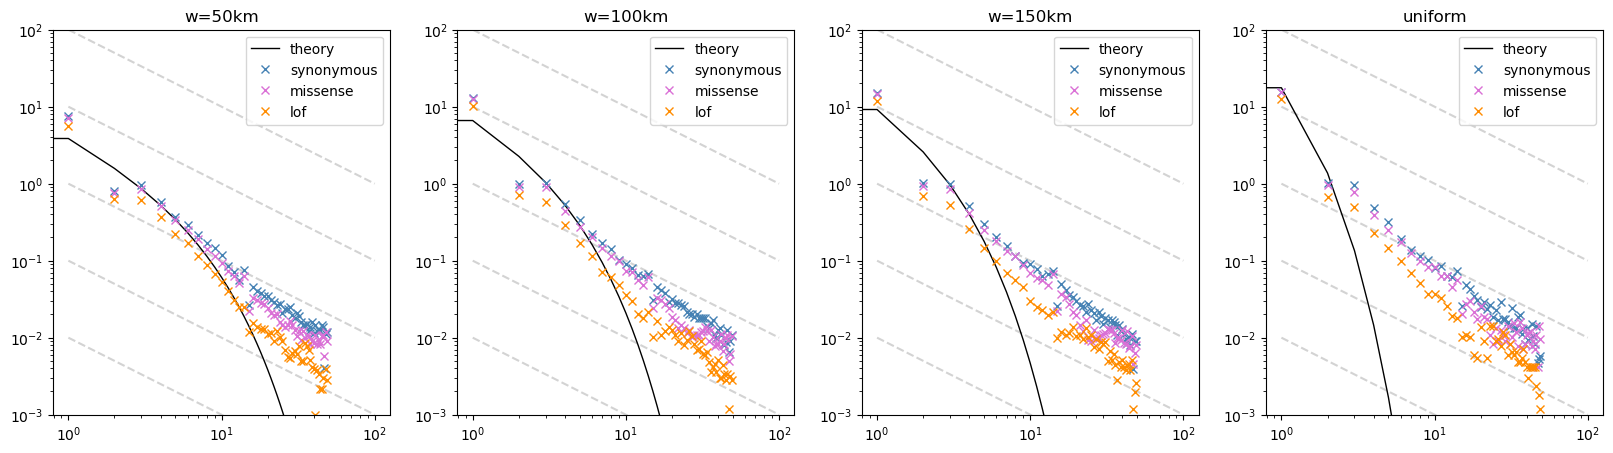

In [13]:
plot_data_vs_theory(10,3.111111111111111,6e-3)

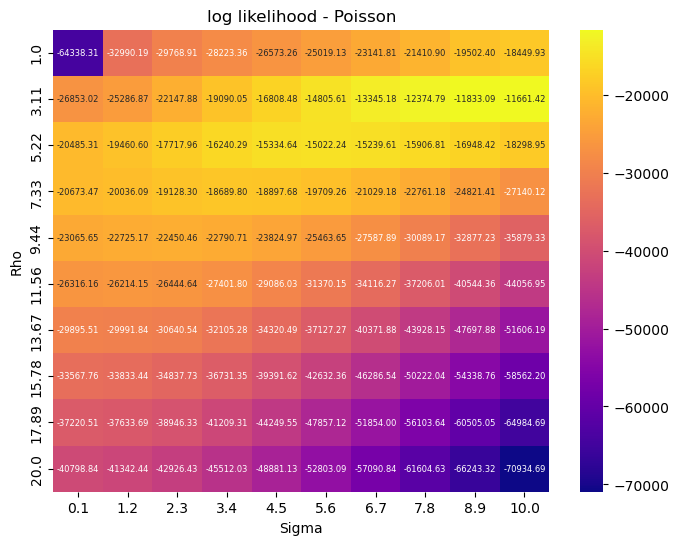

In [14]:
res_df3 = pd.DataFrame(res3,columns=['sigma','rho','s','w','mu','logl'])
plot_log_likelihood(res_df3)